In [207]:
import os
from os.path import join
import glob, re
import numpy as np
import matplotlib.pyplot as plt
from nilearn.image import new_img_like
import nilearn
import pandas as pd
import nibabel as nib
import seaborn as sns
from nilearn import plotting
from nilearn import image
from nilearn import masking
import matplotlib.colors
from rsatoolbox.inference import eval_fixed
from rsatoolbox.model import ModelFixed
from rsatoolbox.rdm import RDMs
from rsatoolbox.util.searchlight import get_volume_searchlight, get_searchlight_RDMs, evaluate_models_searchlight
import rsatoolbox
from scipy.spatial.distance import pdist, squareform

In [208]:

def upper_tri(RDM):
    """upper_tri returns the upper triangular index of an RDM

    Args:
        RDM 2Darray: squareform RDM

    Returns:
        1D array: upper triangular vector of the RDM
    """
    # returns the upper triangle
    m = RDM.shape[0]
    r, c = np.triu_indices(m, 1)
    return RDM[r, c]


def RDMcolormapObject(direction=1):
    """
    Returns a matplotlib color map object for RSA and brain plotting
    """
    if direction == 0:
        cs = ['yellow', 'red', 'gray', 'turquoise', 'blue']
    elif direction == 1:
        cs = ['blue', 'turquoise', 'gray', 'red', 'yellow']
    else:
        raise ValueError('Direction needs to be 0 or 1')
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", cs)
    return cmap
def load_searchlight(singletrial_dir, sub, ses, run):
    """Load single trial average beta estimates within session

    Args:
        singletrial_dir (str): directory containing single trial beta estimates
        sub (str): BIDS subject id
        ses (str): BIDS session id
        run (str): BIDS run id

    Returns:
        np.array: numpy array of shape num_samples num_labels
    """
    from nilearn import datasets
    from nilearn import masking
    get_shape = glob.glob(os.path.join(
            singletrial_dir, sub, f'{sub}_{ses}_run-01_runtype-*_event-stimulus_trial-*_cuetype-high_stimintensity-high.nii.gz'))
    tmp_img = nib.load(get_shape[0])
    x, y, z = tmp_img.get_fdata().shape
    # arr = np.empty((0, get_shape_data.shape[0]), int)
    arr = np.empty((0, tmp_img.get_fdata().ravel().shape[0]), int)
    # Stimulus trials for the given runtype.
    masklist = []
    for runtype in ['pain', 'cognitive', 'vicarious']:
        run = '*'
        stim_H_cue_H = sorted(glob.glob(os.path.join(
            singletrial_dir, sub, f'{sub}_{ses}_{run}_runtype-{runtype}_event-stimulus_trial-*_cuetype-high_stimintensity-high.nii.gz')))
        stim_M_cue_H = sorted(glob.glob(os.path.join(
            singletrial_dir, sub, f'{sub}_{ses}_{run}_runtype-{runtype}_event-stimulus_trial-*_cuetype-high_stimintensity-med.nii.gz')))
        stim_L_cue_H = sorted(glob.glob(os.path.join( 
            singletrial_dir, sub, f'{sub}_{ses}_{run}_runtype-{runtype}_event-stimulus_trial-*_cuetype-high_stimintensity-low.nii.gz')))
        stim_H_cue_L = sorted(glob.glob(os.path.join(
            singletrial_dir, sub, f'{sub}_{ses}_{run}_runtype-{runtype}_event-stimulus_trial-*_cuetype-low_stimintensity-high.nii.gz')))
        stim_M_cue_L = sorted(glob.glob(os.path.join(
            singletrial_dir, sub, f'{sub}_{ses}_{run}_runtype-{runtype}_event-stimulus_trial-*_cuetype-low_stimintensity-med.nii.gz')))
        stim_L_cue_L = sorted(glob.glob(os.path.join(
            singletrial_dir, sub, f'{sub}_{ses}_{run}_runtype-{runtype}_event-stimulus_trial-*_cuetype-low_stimintensity-low.nii.gz')))
        stim_flist = []
        [stim_flist.extend(l) for l in (stim_H_cue_H, stim_M_cue_H,
                           stim_L_cue_H, stim_H_cue_L, stim_M_cue_L, stim_L_cue_L)]

        stim_H_cue_H_mean = image.mean_img(
            image.concat_imgs(stim_H_cue_H)).get_fdata().ravel()
        stim_M_cue_H_mean = image.mean_img(
            image.concat_imgs(stim_M_cue_H)).get_fdata().ravel()
        stim_L_cue_H_mean = image.mean_img(
            image.concat_imgs(stim_L_cue_H)).get_fdata().ravel()
        stim_H_cue_L_mean = image.mean_img(
            image.concat_imgs(stim_H_cue_L)).get_fdata().ravel()
        stim_M_cue_L_mean = image.mean_img(
            image.concat_imgs(stim_M_cue_L)).get_fdata().ravel()
        stim_L_cue_L_mean = image.mean_img(
            image.concat_imgs(stim_L_cue_L)).get_fdata().ravel()
        runwise_array = np.vstack((stim_H_cue_H_mean, stim_M_cue_H_mean, stim_L_cue_H_mean,
                                    stim_H_cue_L_mean, stim_M_cue_L_mean, stim_L_cue_L_mean))
        arr = np.concatenate((arr, runwise_array), axis=0)
        # mask = ~np.isnan(image.load_img(image.concat_imgs([stim_H_cue_H, stim_M_cue_H, stim_L_cue_H,
                                    # stim_H_cue_L, stim_M_cue_L, stim_L_cue_L])).get_fdata())
        masklist.extend([stim_H_cue_H, stim_M_cue_H, stim_L_cue_H,
                                stim_H_cue_L, stim_M_cue_L, stim_L_cue_L])
        # image.concat_imgs([mask, stim_H_cue_H, stim_M_cue_H, stim_L_cue_H,
        #                         stim_H_cue_L, stim_M_cue_L, stim_L_cue_L])
    print(masklist)
    print(len(masklist))
    mask_img = masking.compute_brain_mask(masklist, threshold=.1)
    print(mask_img.get_fdata().shape)
    print(np.sum(~np.isnan(mask_img.get_fdata())))
    return arr, mask_img, x,y,z


def load_expect(data_dir, sub, ses ):
    tasklist = ['pain', 'vicarious', 'cognitive']
    seswise_expect = pd.DataFrame()
    for task in tasklist:
        runwise_df = pd.DataFrame()
        flist = glob.glob(os.path.join(data_dir, sub, ses, f"{sub}_{ses}_*{task}_beh.csv"))
        for f in flist: 
            df = pd.read_csv(f)
            df['trial'] = df.index
            df['trial_order'] = df.groupby('param_cond_type', as_index=False)['param_cond_type'].cumcount()
            runwise_df = pd.concat([runwise_df, df])
        # convert run number
        runwise_df['run_order'] = runwise_df['param_run_num'].gt(np.mean(runwise_df['param_run_num']), 0)*1
        seswise_02expect = runwise_df.pivot_table(index=['param_cue_type','param_stimulus_type'], columns=['trial_order', 'run_order'],
                            values=['event02_expect_angle']) #, aggfunc='first')
        seswise_02expect.columns  = [col[0]+'_'+str(col[1]) for col in seswise_02expect.columns.values]
        seswise_02expect = seswise_02expect.reset_index()
        seswise_02expect["condition"] = task + '_' + seswise_02expect['param_cue_type'].astype(str) + '_' + seswise_02expect["param_stimulus_type"]

        # reorder values
        seswise_02expect['stim_order'] = seswise_02expect['param_stimulus_type'].map({'high_cue':0, 'low_cue':1, 'high_stim':0, 'med_stim':1, 'low_stim':2})  
        seswise_02expect['cue_order'] = seswise_02expect['param_cue_type'].map({'high_cue':0, 'low_cue':1, 'high_stim':0, 'med_stim':1, 'low_stim':2})    
        ses_expect = seswise_02expect.sort_values(['cue_order','stim_order'])
        seswise_expect = pd.concat([seswise_expect, ses_expect])
    return(seswise_expect.reset_index(drop = True))

In [209]:
def get_unique_ses(sub_id, ses, singletrial_dir):
    """
    Extracts unique values of 'ses' and 'run' from a singletrial nifti file

    Args:
        sub_id (str): BIDS subject
        singletrial_dir (str): path to directory containing the singletrial nifti files

    Returns:
        [type]: set of unique values of ses and run
    """

    flist = glob.glob(
        os.path.join(singletrial_dir, sub_id, f"*{ses}*stimulus*trial-000_*.nii.gz")
    )
    # Initialize empty sets to store unique values of 'ses' and 'run'
    unique_ses = set()
    unique_run = set()

    # Loop through each file path and extract 'ses-##' and 'run-##' using regular expressions
    # Extract ses run and ses.
    for path in flist:
        # Extract 'ses-##' using regular expression
        ses_match = re.search(r"ses-(\d+)", path)
        # Add a new session to the unique_ses list
        if ses_match:
            unique_ses.add(ses_match.group(0))

        # Extract 'run-##' using regular expression
        run_match = re.search(r"run-(\d+)", path)
        # Add run_match to unique_run list of run_match. group 0
        if run_match:
            unique_run.add(run_match.group(0))
    return unique_ses, unique_run


In [210]:
# parameters
nifti_dir = '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/singletrial/'
modelRDM_dir = '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/rsa/modelrdm'
canlab_dir = '/Users/h/Documents/MATLAB/CanlabCore'

In [243]:
# fname = "/Users/h/Dropbox/projects_dropbox/social_influence_analysis/resources/sub-0127/sub-0127_ses-01_rsadata.pkl"
# obj = pd.read_pickle(fname)
# # %%
sub = 'sub-0078'
ses = 'ses-01'
run = 'run-02'
fmri_event = 'stimulus'
# set this path to wherever you saved the folder containing the img-files
nifti_dir = '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/singletrial/'
flist = glob.glob(os.path.join(nifti_dir, sub, f"{sub}_{ses}_{run}_*event-stimulus_trial-*.nii.gz"))
arr, mask, x,y,z = load_searchlight(nifti_dir, sub, ses, run)
# tmp_img = nib.load(flist[0]) # load one image to get the dimensions and make the mask
# mask_data = ~np.isnan(mask) # we infer the mask by looking at non-nan voxels
# x, y, z = tmp_img.get_fdata().shape
# tmp_mask = masking.compute_brain_mask(tmp_img)
# data = np.zeros((len(flist), x, y, z)) # loop over all images
# for x, im in enumerate(flist):
#     data[x] = nib.load(im).get_fdata()

[['/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/singletrial/sub-0078/sub-0078_ses-01_run-01_runtype-pain_event-stimulus_trial-005_cuetype-high_stimintensity-high.nii.gz', '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/singletrial/sub-0078/sub-0078_ses-01_run-01_runtype-pain_event-stimulus_trial-008_cuetype-high_stimintensity-high.nii.gz', '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/singletrial/sub-0078/sub-0078_ses-01_run-05_runtype-pain_event-stimulus_trial-006_cuetype-high_stimintensity-high.nii.gz', '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/singletrial/sub-0078/sub-0078_ses-01_run-05_runtype-pain_event-stimulus_trial-011_cuetype-high_stimintensity-high.nii.gz'], ['/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/singletrial/sub-0078/sub-0078_ses-01_run-01_runtype-pain_event-stimulus_trial-004_cuetype-high_stimintensity-med.nii.gz', '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/singletrial/sub-0078/sub-0078_ses-01_run-01_runtype-pain_e

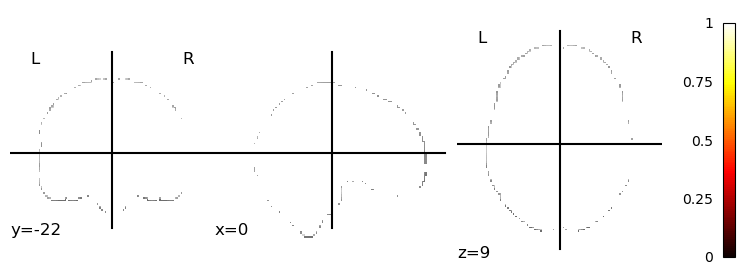

In [244]:
plotting.plot_stat_map(mask)
imgfname = glob.glob(join(nifti_dir, sub, f'{sub}_{ses}_*_runtype-vicarious_event-{fmri_event}_trial-011_cuetype-low_stimintensity-low.nii.gz'))
ref_img = image.load_img(imgfname[0])
nifti_masker = nilearn.maskers.NiftiMasker(mask_img= mask,
                                           
                            target_affine = ref_img.affine, target_shape = ref_img.shape, 
                    memory="nilearn_cache", memory_level=1)

singlemasked = []
for index in range(arr.shape[0]):
    singlemasked.append(
        nifti_masker.fit_transform(
    new_img_like(ref_img, arr[index].reshape(x,y,z)))
    )
fmri_masked_single = np.vstack(singlemasked)

















































































































































































































































































Finding searchlights...: 100%|██████████| 97529/97529 [00:03<00:00, 27168.11it/s]


Found 97040 searchlights










/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/rsatoolbox/rdm/calc.py:209: RuntimeWarning: invalid value encountered in divide
  ma /= np.sqrt(np.einsum('ij,ij->i', ma, ma))[:, None]



























































































































































































































































































































































































































































































































































































































































































































































































































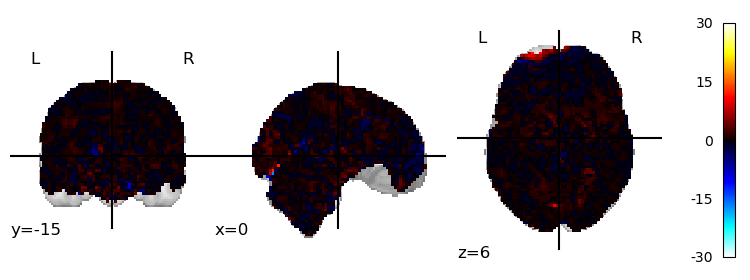

In [319]:
masked_arr = nifti_masker.inverse_transform(fmri_masked_single)
img = new_img_like(ref_img, masked_arr.get_fdata()[..., 0])
plotting.plot_stat_map(img)
# step 01
centers, neighbors = get_volume_searchlight(nifti_masker.mask_img.get_fdata(), radius=2, threshold=0.5)
# # %% Step 2: Get an RDM for each voxel¶

image_value = np.arange(masked_arr.shape[-1])
# data_2d = np.reshape(masked_arr.get_fdata(), (masked_arr.shape[3], -1))
reshaped_array = np.reshape(masked_arr.get_fdata(), (-1, masked_arr.shape[3]))

data_2d = reshaped_array.T #masked_arr.reshape([masked_arr.shape[0], -1])
# data_2d = np.reshape(masked_arr, (masked_arr.shape[0], -1))
data_2d = np.nan_to_num(data_2d)

SL_RDM = get_searchlight_RDMs(data_2d, centers, neighbors, image_value, method='correlation') # Get RDMs


In [236]:
# imgfname = glob.glob(join(nifti_dir, sub, f'{sub}_{ses}_*_runtype-vicarious_event-{fmri_event}_trial-011_cuetype-low_stimintensity-low.nii.gz'))
# ref_img = image.load_img(imgfname[0])

# mask = image.load_img(join(canlab_dir, 'CanlabCore/canlab_canonical_brains/Canonical_brains_surfaces/brainmask_canlab.nii'))
# mask_img = nilearn.masking.compute_epi_mask(mask, target_affine = ref_img.affine, target_shape = ref_img.shape)

# nifti_masker = nilearn.maskers.NiftiMasker(mask_img= mask_img,
                                           
#                             target_affine = ref_img.affine, target_shape = ref_img.shape, 
#                     memory="nilearn_cache", memory_level=1)

# K = arr*mask.get_fdata().ravel()
# K.shape
# # apply mask to stacked fMRI data
# test = mask.get_fdata().ravel() * arr
# print(f"----test----")
# print(f"shape: {test.shape}")
# print(f"any NaNs?: {np.sum(np.isnan(test))}")

# print(f"----mask----")
# print(f"shape: {mask.get_fdata().shape}")
# print(f"any NaNs?: {np.sum(np.isnan(mask.get_fdata()))}")

get searchlight test function

In [188]:
# imgfname = glob.glob(join(nifti_dir, sub, f'{sub}_{ses}_*_runtype-vicarious_event-{fmri_event}_trial-011_cuetype-low_stimintensity-low.nii.gz'))
# ref_img = image.load_img(imgfname[0])

# mask = image.load_img(join(canlab_dir, 'CanlabCore/canlab_canonical_brains/Canonical_brains_surfaces/brainmask_canlab.nii'))
# mask_img = nilearn.masking.compute_epi_mask(mask, target_affine = ref_img.affine, target_shape = ref_img.shape)

# nifti_masker = nilearn.maskers.NiftiMasker(mask_img= mask_img,
                                           
#                             target_affine = ref_img.affine, target_shape = ref_img.shape, 
#                     memory="nilearn_cache", memory_level=1)

# singlemasked = []
# for index in range(arr.shape[0]):
#     singlemasked.append(
#         nifti_masker.fit_transform(
#     new_img_like(ref_img, arr[index].reshape(x,y,z)))
#     )
# fmri_masked_single = np.vstack(singlemasked)

In [67]:
# mask_fname = join(canlab_dir, 'CanlabCore/canlab_canonical_brains/Canonical_brains_surfaces/brainmask_canlab.nii')
# graymattermask = image.load_img(mask_fname)
# target_singletrial =  image.concat_imgs(
#     glob.glob(os.path.join(nifti_dir, sub,
#                     f'{sub}_*_runtype-pain_event-stimulus*_cuetype-high*.nii.gz')))
# resampled_mask = image.resample_img(graymattermask,
#                                 target_affine=target_singletrial.affine,
#                                 target_shape=target_singletrial.shape[0:3],
#                                 interpolation='nearest')
# mask_bool = np.logical_not(np.isnan(resampled_mask.get_fdata())) & (resampled_mask.get_fdata() != 0)

# # mask_bool = np.array(resampled_mask.get_fdata(), dtype = bool)
# mask = image.new_img_like(target_singletrial, mask_bool.astype(int))

/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_49989/3696973877.py:13: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  mask = image.new_img_like(target_singletrial, mask_bool.astype(int))


test 12pm

In [177]:
# # mask = ~np.isnan(arr[0].reshape(masked_arr.get_fdata().shape[0:3]))
# # data_2d = np.nan_to_num(arr)
# # image_value = np.arange(len(arr))
# # centers, neighbors = get_volume_searchlight(mask, radius=3, threshold=0.5)

# resampled_img = image.new_img_like(ref_img, arr[0].reshape(target_singletrial.shape[0:3]),
#                                 )
# mask_bool = np.logical_not(np.isnan(resampled_mask.get_fdata())) & (resampled_mask.get_fdata() != 0)

# # mask_bool = np.array(resampled_mask.get_fdata(), dtype = bool)
# mask = image.new_img_like(ref_img, mask_bool.astype(int))

# K = arr*mask.get_fdata().ravel()
# print(f"masked fMRI array shape: {K.shape}")
# print(f"number of non-NaN values in entire fMRI-array: {np.sum(~np.isnan(K))}")
# # apply mask to stacked fMRI data
# # test = mask.get_fdata().ravel() * arr
# print(f"----K----")
# print(f"shape: {K.shape}")
# print(f"any NaNs?: {np.sum(np.isnan(K))}")

# print(f"----mask----")
# print(f"shape: {mask.get_fdata().shape}")
# print(f"any NaNs?: {np.sum(np.isnan(mask.get_fdata()))}")


# # %% Step 1: Get searchlight centers and neighbors ____________________________________________
# centers, neighbors = get_volume_searchlight(mask.get_fdata(), radius=2, threshold=0.5)

# # %% Step 2: Get an RDM for each voxel¶
# image_value = np.arange(K.shape[0])
# data_2d = np.nan_to_num(K)

# SL_RDM = get_searchlight_RDMs(data_2d, centers, neighbors, image_value, method='correlation') # Get RDMs





/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_49989/1610555739.py:11: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  mask = image.new_img_like(ref_img, mask_bool.astype(int))


masked fMRI array shape: (18, 458294)
number of non-NaN values in entire fMRI-array: 8249292
----K----
shape: (18, 458294)
any NaNs?: 0
----mask----
shape: (73, 86, 73)
any NaNs?: 0


























































































































































































































Finding searchlights...: 100%|██████████| 99837/99837 [00:03<00:00, 25814.77it/s]


Found 99381 searchlights








/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/rsatoolbox/rdm/calc.py:209: RuntimeWarning: invalid value encountered in divide
  ma /= np.sqrt(np.einsum('ij,ij->i', ma, ma))[:, None]
























































































































































































































































































































































































































































































































































































































Calculating RDMs...: 100%|██████████| 100/100 [00:17<00:00,  5.80it/s]


In [314]:
SL_RDM.dissimilarities.shape

(97040, 153)

In [117]:
# # %% Step 1: Get searchlight centers and neighbors ____________________________________________
# centers, neighbors = get_volume_searchlight(~np.isnan(nifti_masker.mask_img.get_fdata()), radius=2, threshold=0.5)

# # %% Step 2: Get an RDM for each voxel¶
# image_value = np.arange(data_2d.shape[0])
# # data_2d = np.nan_to_num(arr)

# SL_RDM = get_searchlight_RDMs(data_2d, centers, neighbors, image_value, method='correlation') # Get RDMs
# # SL_RDM2 = get_searchlight_RDMs(mask.get_fdata().ravel() * arr, centers, neighbors, image_value, method='correlation') # Get RDMs
# # SL_RDM3 = get_searchlight_RDMs(np.nan_to_num(arr), centers, neighbors, image_value, method='correlation') # Get RDMs
































































































































































Finding searchlights...: 100%|██████████| 458294/458294 [00:16<00:00, 27152.45it/s]


Found 458294 searchlights



/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/rsatoolbox/rdm/calc.py:209: RuntimeWarning: invalid value encountered in divide
  ma /= np.sqrt(np.einsum('ij,ij->i', ma, ma))[:, None]




































































































Calculating RDMs...: 100%|██████████| 100/100 [01:18<00:00,  1.27it/s]


In [315]:
data_2d.shape

(18, 458294)

In [318]:
print(f"voxel indices: {SL_RDM.rdm_descriptors['voxel_index'].shape}")
print(f"number of nans?: {np.sum(np.isnan(SL_RDM.dissimilarities))}")
print(f"number of nan in mask? {np.sum(np.isnan(mask.get_fdata()))}")
print(f"centers shape: {centers.shape}")
print(f"searchlight RDM shape: {SL_RDM.dissimilarities.shape}")

voxel indices: (97040,)
number of nans?: 0
number of nan in mask? 0
centers shape: (97040,)
searchlight RDM shape: (97040, 153)


In [294]:
X[0].rdm

array([[0., 0., 2., 2., 2., 0., 0., 0., 2., 2., 2., 0., 0., 0., 2., 2.,
        2., 0., 2., 2., 2., 0., 0., 0., 2., 2., 2., 0., 0., 0., 2., 2.,
        2., 2., 2., 2., 0., 0., 0., 2., 2., 2., 0., 0., 0., 2., 2., 2.,
        0., 0., 2., 2., 2., 0., 0., 0., 2., 2., 2., 0., 0., 0., 0., 2.,
        2., 2., 0., 0., 0., 2., 2., 2., 0., 0., 0., 2., 2., 2., 0., 0.,
        0., 2., 2., 2., 0., 0., 0., 0., 0., 2., 2., 2., 0., 0., 0., 2.,
        2., 2., 0., 2., 2., 2., 0., 0., 0., 2., 2., 2., 2., 2., 2., 0.,
        0., 0., 2., 2., 2., 0., 0., 2., 2., 2., 0., 0., 0., 0., 2., 2.,
        2., 0., 0., 0., 2., 2., 2., 0., 0., 0., 0., 0., 2., 2., 2., 0.,
        2., 2., 2., 2., 2., 2., 0., 0., 0.]])

In [286]:
SL_RDM.dissimilarities[np.isnan(SL_RDM.dissimilarities)] = 0
# rdm2[np.isnan(rdm2)] = 0

# Now you can pass the modified arrays to the compare function
# similarity = compare(rdm1, rdm2)

In [123]:
main_dir = '/Volumes/spacetop_projects_cue/'


In [321]:
# %% Step 3: Load animal model and evaluate
# model_grid ________________________________________________________________________________
modelRDM_dir = os.path.join(main_dir,'analysis/fmri/nilearn/rsa/modelrdm')
cue_RDM = np.load(os.path.join(modelRDM_dir, 'model-cue.npy'))
stim_RDM = np.load(os.path.join(modelRDM_dir, 'model-stim.npy'))
grid_RDM = np.load(os.path.join(modelRDM_dir, 'model-grid.npy'))
orthogonal_RDM = np.load(os.path.join(modelRDM_dir, 'model-orthogonal.npy'))
rotationgrid_RDM = np.load(os.path.join(modelRDM_dir, 'model-rotationgrid.npy'))
parallel_RDM = np.load(os.path.join(modelRDM_dir, 'model-parallel.npy'))
diagonal_RDM = np.load(os.path.join(modelRDM_dir, 'model-diagonal.npy'))
# essential
SL_RDM.dissimilarities[np.isnan(SL_RDM.dissimilarities)] = 0
# %%
X = [rsatoolbox.model.ModelWeighted('cue', upper_tri(cue_RDM)),
     rsatoolbox.model.ModelWeighted('stim', upper_tri(stim_RDM)),
     rsatoolbox.model.ModelWeighted('grid', upper_tri(grid_RDM)),
     rsatoolbox.model.ModelWeighted('orthogonal', upper_tri(orthogonal_RDM)),
     rsatoolbox.model.ModelWeighted('rotationgrid', upper_tri(rotationgrid_RDM)),
     rsatoolbox.model.ModelWeighted('parallel', upper_tri(parallel_RDM)),
     rsatoolbox.model.ModelWeighted('diagonal', upper_tri(diagonal_RDM))]
model_names = ['cue', 'stim', 'grid', 'orthogonal', 'rotationgrid',  'parallel', 'diagonal']   
eval_results = evaluate_models_searchlight(SL_RDM, X, eval_fixed, method='spearman', n_jobs=3)
# TODO: sklearn linear regression and dot fit. dot coef. fit intercept
# SL_RDM1 and X. zscore and rank. standardized rank regression


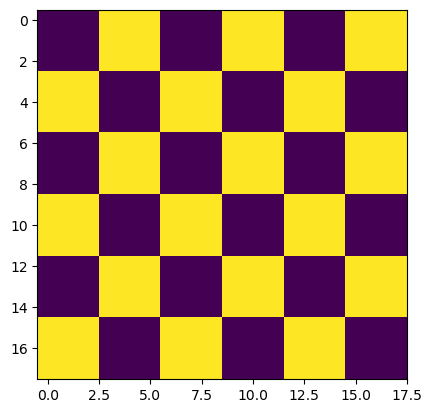

In [312]:
plt.imshow(squareform(pdist(cue_RDM)))

/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_49989/4017835145.py:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.T[model_i].tolist())


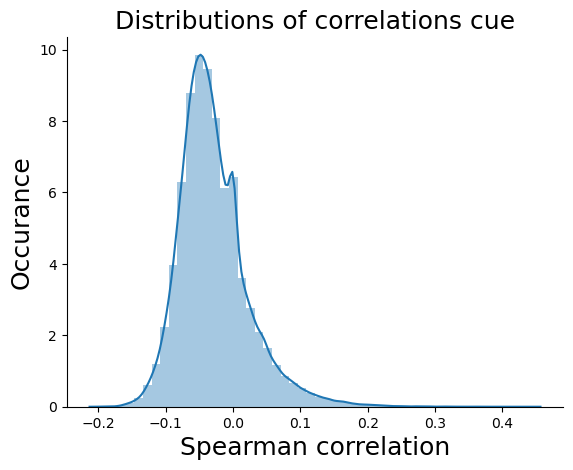

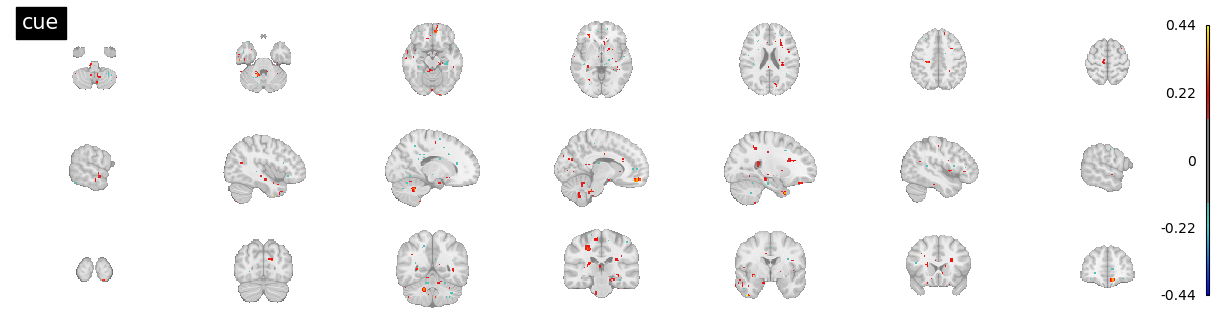

/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_49989/4017835145.py:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.T[model_i].tolist())


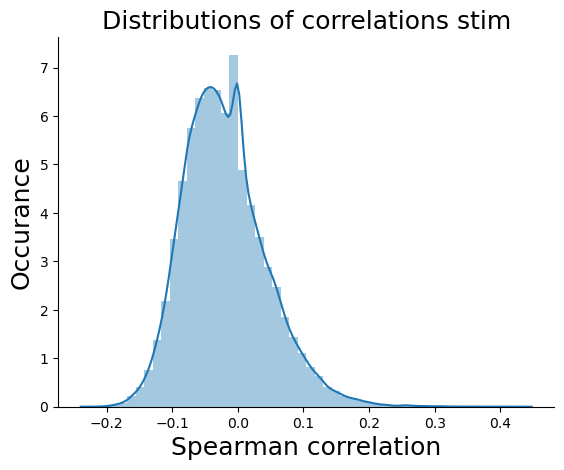

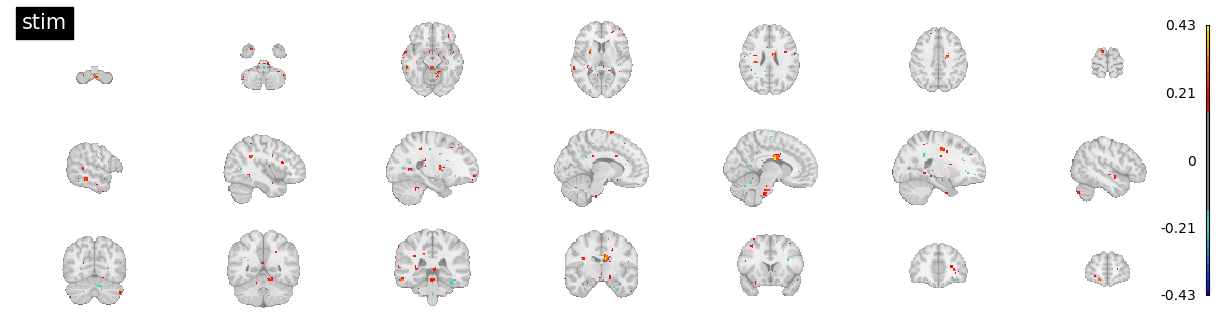

/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_49989/4017835145.py:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.T[model_i].tolist())


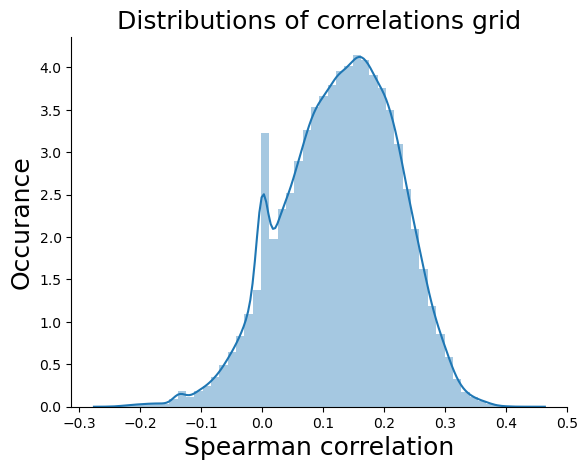

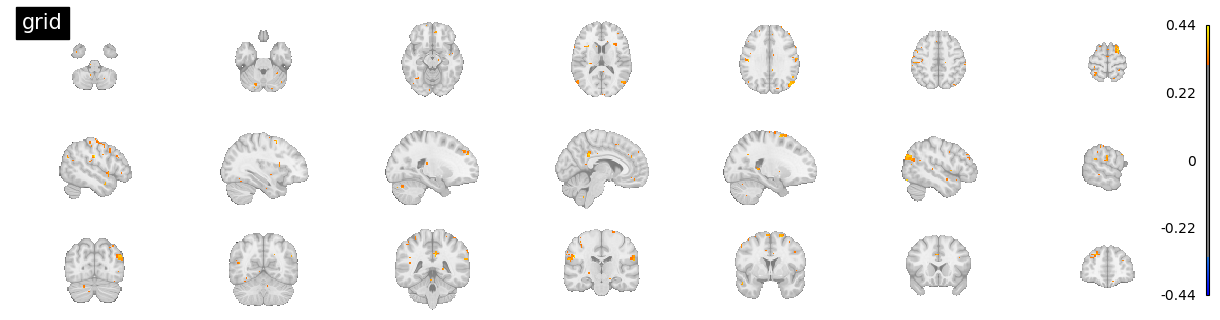

/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_49989/4017835145.py:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.T[model_i].tolist())


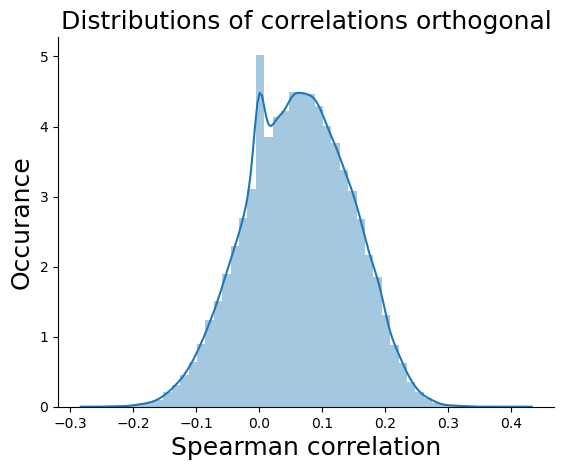

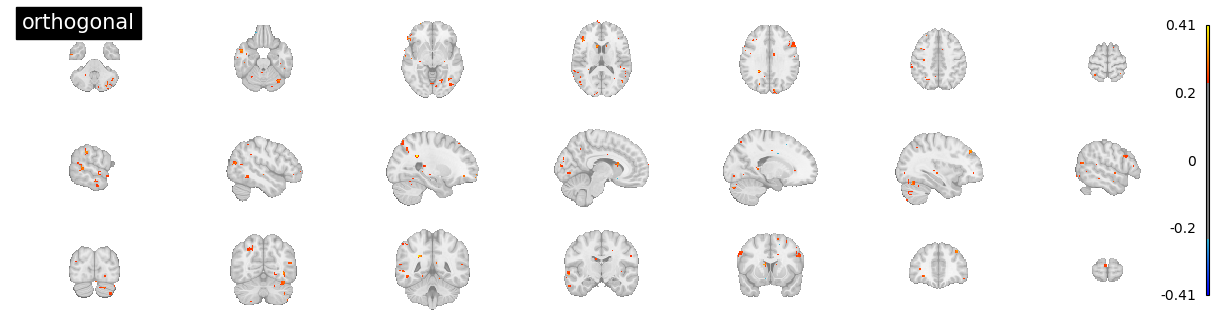

/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_49989/4017835145.py:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.T[model_i].tolist())


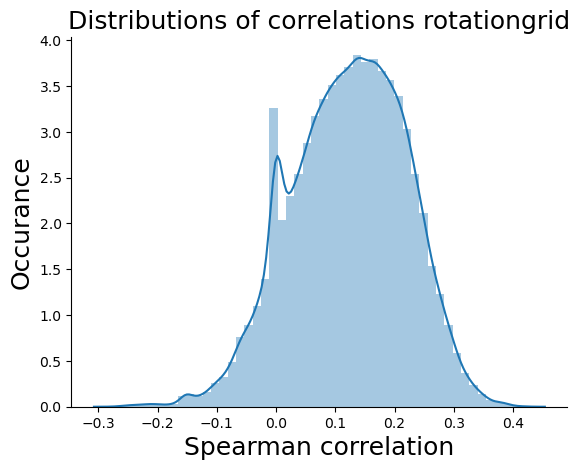

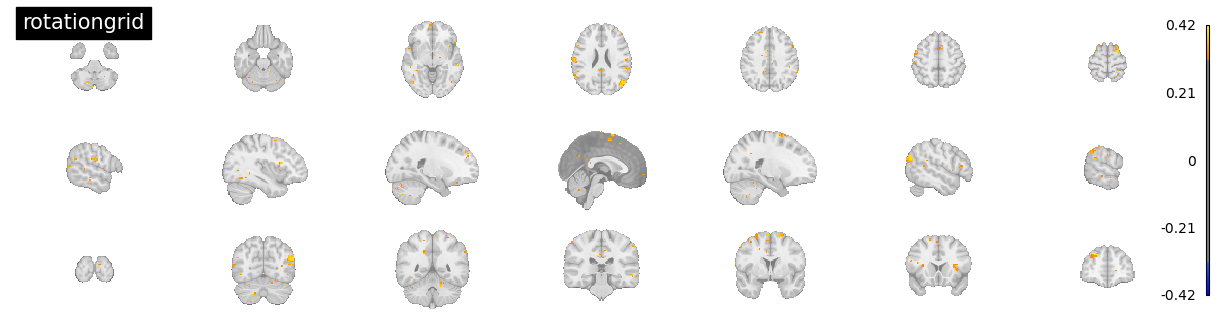

/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_49989/4017835145.py:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.T[model_i].tolist())


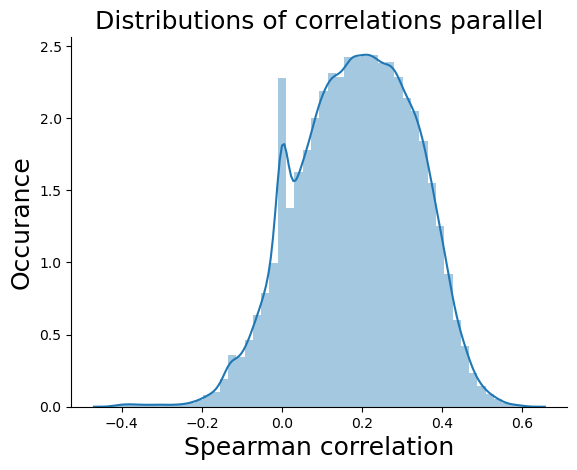

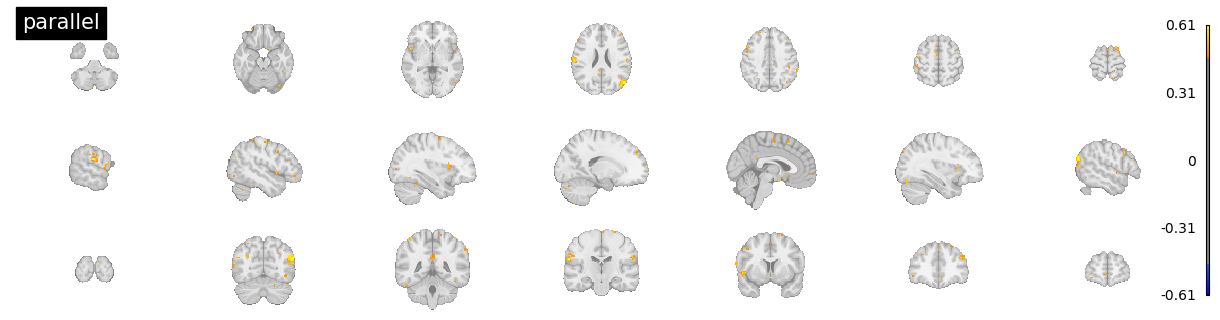

/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_49989/4017835145.py:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.T[model_i].tolist())


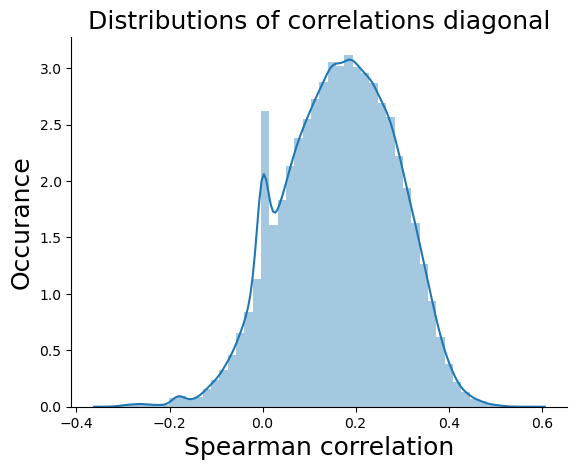

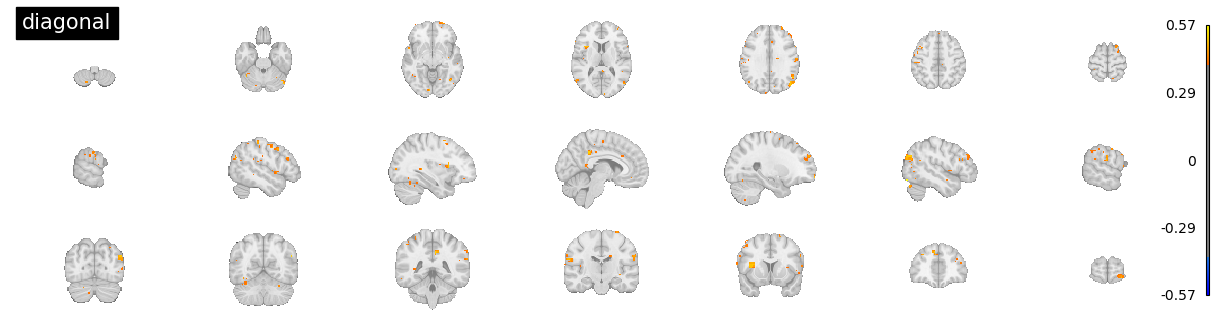

In [313]:

# %%
df = pd.DataFrame(index=range(len(X)), columns=range(len(eval_results)))
for i, e in enumerate(eval_results):
    df.iloc[:,i] = e.evaluations[0]

# %% Create an 3D array, with the size of mask, and

for model_i, model_name in enumerate(model_names):
    x, y, z = mask.shape
    RDM_brain = np.zeros([x*y*z])
    RDM_brain[list(SL_RDM.rdm_descriptors['voxel_index'])] = df.T[model_i].tolist()
    RDM_brain = RDM_brain.reshape([x, y, z])

    sns.distplot(df.T[model_i].tolist())
    plt.title(f'Distributions of correlations {model_name}', size=18)
    plt.ylabel('Occurance', size=18)
    plt.xlabel('Spearman correlation', size=18)
    sns.despine()
    plt.show()

    # lets plot the voxels above the 99th percentile
    threshold = np.percentile(df.T[model_i].tolist(), 99)
    plot_img = new_img_like(mask, RDM_brain)

    cmap = RDMcolormapObject()

    coords = range(-20, 40, 5)
    fig = plt.figure(figsize=(12, 3))

    display = plotting.plot_stat_map(
            plot_img, colorbar=True, threshold=threshold,
            display_mode='mosaic', draw_cross=False, figure=fig,
            title=f'{model_name}', cmap=cmap,
            black_bg=False, annotate=False) #cut_coords=coords,
    plt.show()

In [28]:
# eval_results = evaluate_models_searchlight(SL_RDM, X, eval_fixed, method='spearman', n_jobs=3)
results_1 = rsatoolbox.inference.eval_fixed(X, SL_RDM, method='corr')
rsatoolbox.vis.plot_model_comparison(results_1)

KeyboardInterrupt: 